In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
# !pip install pyarrow
# !pip install fastparquet
# !pip install xgboost


# Method of preprocessing
1. Import the datasets
2. Transform the datasets into hourly format
3. Handle missing values and rows
4. Final feature engineering and storing
5. Create additional combined super-dataset

# 1. Import the datasets

In [3]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

In [4]:
x_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
x_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
x_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

In [5]:
x_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
x_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
x_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')


In [6]:
x_test_a = pd.read_parquet('A/X_test_estimated.parquet')
x_test_b = pd.read_parquet('B/X_test_estimated.parquet')
x_test_c = pd.read_parquet('C/X_test_estimated.parquet')


In [7]:
x_train_a = pd.concat([x_train_observed_a,x_train_estimated_a])
x_train_b = pd.concat([x_train_observed_b,x_train_estimated_b])
x_train_c = pd.concat([x_train_observed_c,x_train_estimated_c])

# 2. Transform into quarterly

- Observed and estimated measurements are taken every 15 minutes, while energy is measured every hour
- We need to transform the measurements into hourly aggregations to match the labels

In [8]:
def resample(df, datetime_column='time', value_column='pv_measurement'):
    # Set the datetime column as the index
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    df = df.set_index(datetime_column)

    # Resample the dataframe to 15-minute intervals and forward fill the values
    df_resampled = df.resample('15T').ffill()

    # Adjust the pv_measurement values to be a quarter of the original
    df_resampled[value_column] /= 4

    # Reset the index if you want the timestamp as a column
    df_resampled = df_resampled.reset_index()

    return df_resampled

train_a = resample(train_a)
train_b = resample(train_b)
train_c = resample(train_c)
train_a.head()

,time,pv_measurement
0,2019-06-02 22:00:00,0.0
1,2019-06-02 22:15:00,0.0
2,2019-06-02 22:30:00,0.0
3,2019-06-02 22:45:00,0.0
4,2019-06-02 23:00:00,0.0


# 3. Handle missing values and rows
- Remove NaN pv measurement values from y
- Remove outliers in y_train
- Remove rows that are not present in both x and y
- Merge the test sets with the test.csv file to ensure the right data is being predicted

In [9]:
# Identify the indices of the rows with NaN values in the 'pv_measurement' column
nan_indices_a = train_a[train_a['pv_measurement'].isna()].index
nan_indices_b = train_b[train_b['pv_measurement'].isna()].index
nan_indices_c = train_c[train_c['pv_measurement'].isna()].index

# Drop these indices from y_train
train_a = train_a.drop(nan_indices_a)
train_b = train_b.drop(nan_indices_b)
train_c = train_c.drop(nan_indices_c)


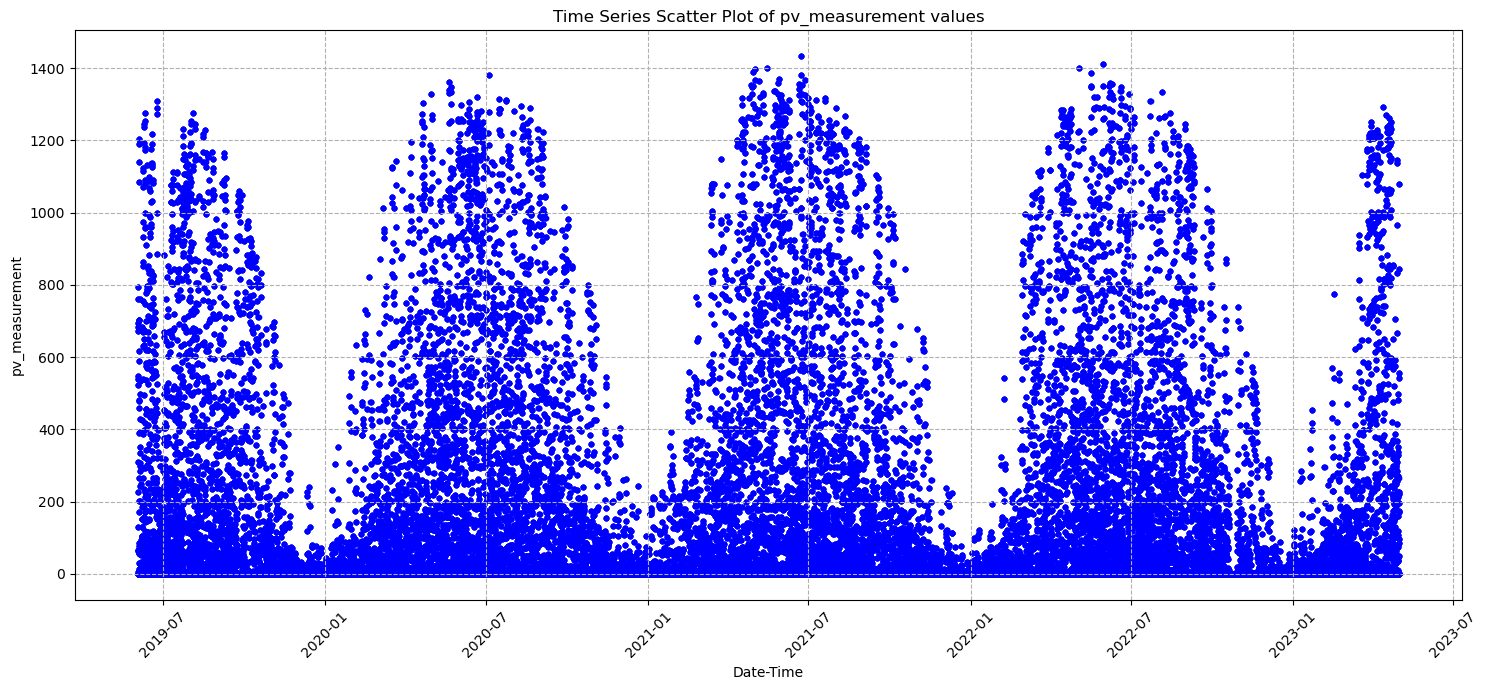

(137093, 2)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your data frame and 'datetime_column' is the column name with date-time values
plt.figure(figsize=(15, 7))
plt.scatter(train_a['time'], train_a['pv_measurement'], color='blue', s=10)  # 's' controls the size of scatter points
plt.title('Time Series Scatter Plot of pv_measurement values')
plt.xlabel('Date-Time')
plt.ylabel('pv_measurement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which="both", ls="--")
plt.show()
train_a.shape

In [11]:
# Currently this makes worse predictions.
import pandas as pd

def remove_nighttime_outliers(df: pd.DataFrame, threshold: float = 100) -> pd.DataFrame:
    # Convert 'time' column to datetime format
    df['time'] = pd.to_datetime(df['time'])
    # Extract hour from 'time' column
    df['time_hour'] = df['time'].dt.hour
    # Define nighttime hours
    nighttime_hours = set(range(0, 2))
    # Identify outliers
    outliers = df[(df['time_hour'].isin(nighttime_hours)) & (df['pv_measurement'] > threshold)]
    # Remove outliers
    df = df.drop(outliers.index)
    # Drop the 'time_hour' column if not needed
    df.drop(columns=['time_hour'], inplace=True)
    
    return df

# Apply function to each dataframe
# train_a = remove_nighttime_outliers(train_a)
# train_b = remove_nighttime_outliers(train_b)
# train_c = remove_nighttime_outliers(train_c)


In [12]:
def filter_consecutive_measurements(df: pd.DataFrame, threshold: int = 48) -> pd.DataFrame:
    """
    Filters out rows from a DataFrame where the 'pv_measurement' column has consecutive 
    identical values beyond a specified threshold.
    
    Parameters:
    - df: Input DataFrame to be processed.
    - threshold: Maximum allowable number of consecutive identical values. Rows in streaks 
      beyond this threshold will be removed.
      
    Returns:
    - Filtered DataFrame.
    """
    # Create a mask to identify where the current 'pv_measurement'-row is different from the previous one
    is_different = df['pv_measurement'] != df['pv_measurement'].shift()
    # Use cumsum to generate unique group identifiers for each streak of identical measurements
    groups = is_different.cumsum()
    # Count the number of entries in each group
    df['group_counts'] = df.groupby(groups)['pv_measurement'].transform('count')
    # Identify groups that exceed the specified threshold
    to_remove = df['group_counts'] > threshold
    # Drop the temporary 'group_counts' column
    df = df.drop(columns=['group_counts'])
    # Filter out the rows belonging to groups that exceed the threshold
    filtered_df = df[~to_remove]
    return filtered_df


train_a = filter_consecutive_measurements(train_a)
train_b = filter_consecutive_measurements(train_b)
train_c = filter_consecutive_measurements(train_c)


In [13]:
# Remove all rows with date-time values that are not present in both x and y in order to synchronize x and its labels. 
def remove_non_synchronous_rows(x_train, y_train, x_date_column='date_forecast', y_date_column='time'):
    # Convert date columns to datetime format for easier comparison
    x_train[x_date_column] = pd.to_datetime(x_train[x_date_column])
    y_train[y_date_column] = pd.to_datetime(y_train[y_date_column])
    
    # Find common dates
    common_dates = x_train[x_date_column][x_train[x_date_column].isin(y_train[y_date_column])]
    
    # Filter both datasets based on common dates
    x_train_synced = x_train[x_train[x_date_column].isin(common_dates)]
    y_train_synced = y_train[y_train[y_date_column].isin(common_dates)]
    
    return x_train_synced, y_train_synced

# Remove the rows with date and time that only shows up in one of the sets
x_train_a, train_a = remove_non_synchronous_rows(x_train_a, train_a)
x_train_b, train_b = remove_non_synchronous_rows(x_train_b, train_b)
x_train_c, train_c = remove_non_synchronous_rows(x_train_c, train_c)

x_train_a.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc
count,95821,95821.000000,95821.000000,75293.000000,9.582100e+04,95821.000000,87895.000000,95821.000000,95821.000000,95821.000000,9.582100e+04,95821.000000,9.582100e+04,95821.000000,95821.0,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,1694.0,95821.000000,95821.0,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,8609
mean,2021-04-28 23:43:33.391636480,7.119030,1.243528,3075.200195,7.842703e+05,217.952301,1760.031860,0.020966,277.964661,59.752628,2.148019e+05,74.621384,2.686168e+05,65.689095,6.0,0.049803,0.002874,0.097897,0.009415,0.021180,0.705023,0.340896,1011.456665,0.005604,0.076674,998.587097,1004.669434,0.150591,0.012630,72.826889,1010.778687,250.0,0.041508,0.0,0.000091,0.076865,179.345551,10.848513,0.056334,281.853546,72.462845,32238.380859,2.974719,0.790552,0.271452,0.000024,2023-02-24 21:36:51.086188800
min,2019-06-02 22:00:00,0.700000,1.145000,27.799999,0.000000e+00,0.000000,28.000000,-1.000000,250.899994,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,949.799988,0.000000,0.000000,937.500000,943.299988,0.000000,0.000000,21.500000,949.099976,250.0,0.000000,0.0,-0.000000,0.000000,0.002000,-34.247002,0.000000,258.899994,0.000000,257.700012,0.000000,-7.300000,-9.300000,-0.000000,2022-10-28 07:00:05
25%,2020-05-23 20:45:00,4.800000,1.220000,1148.000000,0.000000e+00,0.000000,574.599976,0.000000,273.100006,0.000000,0.000000e+00,0.000000,0.000000e+00,38.900002,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1004.400024,0.000000,0.000000,991.599976,997.599976,0.000000,0.000000,62.799999,1003.700012,250.0,0.000000,0.0,0.000000,0.000000,102.459000,-2.074000,0.000000,276.899994,49.400002,15969.900391,1.600000,-1.400000,-1.000000,0.000000,2023-01-22 08:00:03
50%,2021-05-14 10:30:00,7.200000,1.241000,2014.900024,3.341381e+05,92.099998,1122.099976,0.000000,279.200012,36.799999,1.322637e+05,5.000000,2.519570e+04,77.500000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1012.299988,0.000000,0.000000,999.400024,1005.500000,0.000000,0.000000,75.300003,1011.599976,250.0,0.000000,0.0,0.000000,0.000000,178.910004,8.484000,0.000000,282.399994,91.800003,35699.000000,2.600000,0.500000,0.200000,0.000000,2023-03-15 08:00:04
75%,2022-05-06 11:15:00,9.000000,1.266000,4301.000000,1.435910e+06,399.700012,2127.449951,0.000000,282.700012,95.599998,3.444105e+05,88.000000,3.222289e+05,98.599998,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1019.299988,0.000000,0.000000,1006.299988,1012.400024,0.000000,0.000000,84.800003,1018.599976,250.0,0.000000,0.0,0.000000,0.100000,256.549988,24.618000,0.100000,286.100006,99.900002,47483.500000,4.000000,2.800000,1.400000,0.000000,2023-04-07 07:00:35
max,2023-04-30 23:00:00,17.500000,1.427000,12214.299805,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,1.205498e+06,688.700012,2.451173e+06,100.000000,6.0,

In [14]:
# Adding a column called time for merging with test.csv
x_test_a['time'] = pd.to_datetime(x_test_a['date_forecast']).dt.floor('H')
x_test_b['time'] = pd.to_datetime(x_test_b['date_forecast']).dt.floor('H')
x_test_c['time'] = pd.to_datetime(x_test_c['date_forecast']).dt.floor('H')

# Reading the test.csv file
test_df = pd.read_csv("test.csv")
test_df["time"] = pd.to_datetime(test_df["time"])


# Merging the test-sets with the test.csv, and dropping the new columns.
x_test_a = test_df[test_df['location'] == 'A'].merge(x_test_a, on="time", how="right")
x_test_b = test_df[test_df['location'] == 'B'].merge(x_test_b, on="time", how="inner")
x_test_c = test_df[test_df['location'] == 'C'].merge(x_test_c, on="time", how="inner")

x_test_a.drop(columns=["time", "id", "prediction"], inplace=True)
x_test_b.drop(columns=["time", "id", "prediction"], inplace=True)
x_test_c.drop(columns=["time", "id", "prediction"], inplace=True)

# 4. Final feature engineering and storing
- Extract year, month, day and hour features from each datetime column
- Add lag features
- For pv_measurement between 0 and 4, it should be around 0. We remove the outliers that are over 100.
- Store the cleaned data for each location

In [15]:
# Extracts year, month, day, and hour features from a given datetime column
def extract_date_features(df, date_column, prefix):
    # Convert to datetime
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract features
    df[f'{prefix}_year'] = df[date_column].dt.year
    df[f'{prefix}_month'] = df[date_column].dt.month
    df[f'{prefix}_day'] = df[date_column].dt.day
    df[f'{prefix}_hour'] = df[date_column].dt.hour
    
    # # Drop the original date column
    if date_column == 'date_calc':
        df.drop(columns = ['date_calc'], inplace = True)
    # df.drop(columns=[date_column], inplace=True)

# List of datasets
datasets = [x_train_a, x_train_b, x_train_c, x_test_a, x_test_b, x_test_c]

# Loop through datasets and extract date-time features for both date_forecast, date_calc and 'time'
for dataset in datasets:
    if 'date_forecast' in dataset.columns:
        extract_date_features(dataset, 'date_forecast', 'forecast')
    if 'date_calc' in dataset.columns:
        extract_date_features(dataset, 'date_calc', 'calc')

In [16]:
# Set date-time to index
x_train_a.set_index("date_forecast", inplace= True)
x_test_a.set_index('date_forecast', inplace= True)
train_a.set_index('time', inplace= True)

x_train_b.set_index("date_forecast", inplace= True)
x_test_b.set_index('date_forecast', inplace= True)
train_b.set_index('time', inplace= True)

x_train_c.set_index("date_forecast", inplace= True)
x_test_c.set_index('date_forecast', inplace= True)
train_c.set_index('time', inplace= True)

In [17]:
# Adding lag features for past year, and the two years before that. 
def add_lag_features(x,y):
    target_map = y['pv_measurement'].to_dict()
    x['lag_1'] = (x.index - pd.Timedelta('365 days')).map(target_map)
    x['lag_2'] = (x.index - pd.Timedelta('730 days')).map(target_map)
    x['lag_3'] = (x.index - pd.Timedelta('1095 days')).map(target_map)
    return x

In [18]:
# Does not help

# x_train_a_hourly = add_lag_features(x_train_a_hourly,train_a)
# x_train_b_hourly = add_lag_features(x_train_b_hourly,train_b)
# x_train_c_hourly = add_lag_features(x_train_c_hourly,train_c)

# x_test_a_hourly = add_lag_features(x_test_a_hourly, train_a)
# x_test_b_hourly = add_lag_features(x_test_b_hourly, train_b)
# x_test_c_hourly = add_lag_features(x_test_c_hourly, train_c)

# x_test_a_hourly

In [19]:
# Creating cyclical features for hour of the day
def cyclic_hourly(x):
    train_data = x.copy()
    train_data['hour_sin'] = np.sin(2 * np.pi * train_data['forecast_hour'] / 24)
    train_data['hour_cos'] = np.cos(2 * np.pi * train_data['forecast_hour'] / 24)
    return train_data


# Creating cyclical features for month of the year
def cyclic_monthly(x):
    train_data = x.copy()
    train_data['month_sin'] = np.sin(2 * np.pi * train_data['forecast_month'] / 12)
    train_data['month_cos'] = np.cos(2 * np.pi * train_data['forecast_month'] / 12)
    return train_data

def cyclic_day_of_year(x):
    # Reset the index if 'date_forecast' is currently set as the index
    train_data = x.copy()
    train_data.reset_index(inplace=True)
    # Calculate the day of the year from 'date_forecast'
    train_data['day_of_year'] = train_data['date_forecast'].dt.dayofyear
    # Constants for sine and cosine calculations
    days_in_year = 366  # Considering leap years
    # Create sine and cosine features for cyclical encoding of the day of the year
    train_data['day_of_year_sin'] = np.sin(2 * np.pi * train_data['day_of_year'] / days_in_year)
    train_data['day_of_year_cos'] = np.cos(2 * np.pi * train_data['day_of_year'] / days_in_year)
    # Check the dataframe with the new cyclical features
    train_data[['day_of_year', 'day_of_year_sin', 'day_of_year_cos']].head()
    train_data.set_index('date_forecast', inplace=True)
    return train_data

In [20]:
x_train_a = cyclic_hourly(x_train_a)
x_train_a = cyclic_monthly(x_train_a)
x_train_a = cyclic_day_of_year(x_train_a)

x_test_a = cyclic_hourly(x_test_a)
x_test_a = cyclic_monthly(x_test_a)
x_test_a = cyclic_day_of_year(x_test_a)

x_train_b = cyclic_hourly(x_train_b)
x_train_b = cyclic_monthly(x_train_b)
x_train_b = cyclic_day_of_year(x_train_b)

x_test_b = cyclic_hourly(x_test_b)
x_test_b = cyclic_monthly(x_test_b)
x_test_b = cyclic_day_of_year(x_test_b)

x_train_c = cyclic_hourly(x_train_c)
x_train_c = cyclic_monthly(x_train_c)
x_train_c = cyclic_day_of_year(x_train_c)

x_test_c = cyclic_hourly(x_test_c)
x_test_c = cyclic_monthly(x_test_c)
x_test_c = cyclic_day_of_year(x_test_c)

x_train_a.head()


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,forecast_year,forecast_month,forecast_day,forecast_hour,calc_year,calc_month,calc_day,calc_hour,hour_sin,hour_cos,month_sin,month_cos,day_of_year,day_of_year_sin,day_of_year_cos
date_forecast,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,0.0,0.0,0.0,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,NaN,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.0,39640.101562,3.7,-3.6,-0.8,-0.0,2019,6,2,22,NaN,NaN,NaN,NaN,-0.500000,0.866025,1.224647e-16,-1.0,153,0.492548,-0.870285
2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,0.0,0.0,0.0,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,NaN,0.0,0.0,-0.0,0.2,346.294006,-3.650,0.0,286.100006,100.0,40123.898438,3.6,-3.6,-0.6,-0.0,2019,6,2,22,NaN,NaN,NaN,NaN,-0.500000,0.866025,1.224647e-16,-1.0,153,0.492548,-0.870285
2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,0.0,0.0,0.0,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,NaN,0.0,0.0,-0.0,0.2,349.768005,-3.998,0.0,286.299988,100.0,40628.300781,3.6,-3.6,-0.4,-0.0,2019,6,2,22,NaN,NaN,NaN,NaN,-0.500000,0.866025,1.224647e-16,-1.0,153,0.492548,-0.870285
2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,0.0,0.0,0.0,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,NaN,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.0,41153.601562,3.5,-3.5,-0.2,-0.0,2019,6,2,22,NaN,NaN,NaN,NaN,-0.500000,0.866025,1.224647e-16,-1.0,153,0.492548,-0.870285
2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,0.0,0.0,0.0,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,NaN,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.0,41699.898438,3.5,-3.5,0.0,-0.0,2019,6,2,23,NaN,NaN,NaN,NaN,-0.258819,0.965926,1.224647e-16,-1.0,153,0.492548,-0.870285


In [21]:
def add_rolling_and_interaction_features(x):
    data = x.copy()
    # Calculate rolling averages for 'direct_rad:W' and 'diffuse_rad:W'
    data['direct_rad_3h_roll_avg'] = data['direct_rad:W'].rolling('3H').mean()
    data['diffuse_rad_3h_roll_avg'] = data['diffuse_rad:W'].rolling('3H').mean()
    data['direct_rad_6h_roll_avg'] = data['direct_rad:W'].rolling('6H').mean()
    data['diffuse_rad_6h_roll_avg'] = data['diffuse_rad:W'].rolling('6H').mean()

    # Create interaction term between 'direct_rad:W' and 'sun_elevation:d'
    data['direct_rad_x_sun_elevation'] = data['direct_rad:W'] * data['sun_elevation:d']
    return data


x_train_a = add_rolling_and_interaction_features(x_train_a)
x_train_b = add_rolling_and_interaction_features(x_train_b)
x_train_c = add_rolling_and_interaction_features(x_train_c)

x_test_a = add_rolling_and_interaction_features(x_test_a)
x_test_b = add_rolling_and_interaction_features(x_test_b)
x_test_c = add_rolling_and_interaction_features(x_test_c)

In [22]:
# Store the cleaned datasets
output_dir = 'cleaned_data_quarterly'
# Ensure directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Directories for each location
dir_a = os.path.join(output_dir, 'A')
dir_b = os.path.join(output_dir, 'B')
dir_c = os.path.join(output_dir, 'C')

# Ensure subdirectories exist
for dir_path in [dir_a, dir_b, dir_c]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)



# Saving datasets for location A
x_train_a.to_csv(os.path.join(dir_a, 'x_train_a.csv'))
x_test_a.to_csv(os.path.join(dir_a, 'x_test_a.csv'), index=False)
train_a.to_csv(os.path.join(dir_a, 'train_a.csv'))

# Saving datasets for location B
x_train_b.to_csv(os.path.join(dir_b, 'x_train_b.csv'))
x_test_b.to_csv(os.path.join(dir_b, 'x_test_b.csv'), index=False)
train_b.to_csv(os.path.join(dir_b, 'train_b.csv'))

# Saving datasets for location C
x_train_c.to_csv(os.path.join(dir_c, 'x_train_c.csv'))
x_test_c.to_csv(os.path.join(dir_c, 'x_test_c.csv'), index=False)
train_c.to_csv(os.path.join(dir_c, 'train_c.csv'))


In [23]:
x_train_a.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,forecast_year,forecast_month,forecast_day,forecast_hour,calc_year,calc_month,calc_day,calc_hour,hour_sin,hour_cos,month_sin,month_cos,day_of_year,day_of_year_sin,day_of_year_cos,direct_rad_3h_roll_avg,diffuse_rad_3h_roll_avg,direct_rad_6h_roll_avg,diffuse_rad_6h_roll_avg,direct_rad_x_sun_elevation
count,95821.000000,95821.000000,75293.000000,9.582100e+04,95821.000000,87895.000000,95821.000000,95821.000000,95821.000000,9.582100e+04,95821.000000,9.582100e+04,95821.000000,95821.0,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,1694.0,95821.000000,95821.0,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,8609.000000,8609.000000,8609.000000,8609.000000,9.582100e+04,95821.000000,9.582100e+04,9.582100e+04,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000,95821.000000
mean,7.119030,1.243528,3075.200195,7.842703e+05,217.952301,1760.031860,0.020966,277.964661,59.752628,2.148019e+05,74.621384,2.686168e+05,65.689095,6.0,0.049803,0.002874,0.097897,0.009415,0.021180,0.705023,0.340896,1011.456665,0.005604,0.076674,998.587097,1004.669434,0.150591,0.012630,72.826889,1010.778687,250.0,0.041508,0.0,0.000091,0.076865,179.345551,10.848513,0.056334,281.853546,72.462845,32238.380859,2.974719,0.790552,0.271452,0.000024,2020.838762,6.350049,15.797310,11.364596,2022.809502,4.610059,16.231967,7.601696,4.855591e-02,-0.147927,-5.489919e-02,-2.915736e-01,177.763413,0.028031,-0.298180,74.484955,59.415153,73.927869,58.727949,2398.437500
std,2.801408,0.034373,2663.160400,9.192684e+05,256.085144,1885.067871,0.175977,6.465923,67.852882,2.406317e+05,131.676804,4.664484e+05,34.676895,0.0,0.430779,0.060837,0.704052,0.140704,0.244846,0.456031,0.473809,11.641092,0.036031,0.331757,11.516308,11.572248,2.328571,0.049517,14.628156,11.629735,0.0,0.365132,0.0,0.002419,0.215283,97.211830,18.624014,0.106162,6.428008,34.508911,17728.998047,1.759679,2.825080,1.807095,0.001549,1.179722,2.714000,8.785303,6.319143,0.392717,3.366961,8.612918,0.489577,6.838920e-01,0.712785,7.436081e-01,5.991890e-01,82.531892,0.740866,0.601190,126.639811,65.461980,117.202192,60.618283,5194.332520
min,0.700000,1.145000,27.799999,0.000000e+00,0.000000,28.000000,-1.000000,250.899994,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,949.799988,0.000000,0.000000,937.500000,943.299988,0.000000,0.000000,21.500000,949.099976,250.0,0.000000,0.0,-0.000000,0.000000,0.002000,-34.247002,0.000000,258.899994,0.000000,257.700012,0.000000,-7.300000,-9.300000,-0.000000,2019.000000,1.000000,1.000000,0.000000,2022.000000,1.000000,1.000000,7.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,-0.999963,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
25%,4.800000,1.220000,1148.000000,0.000000e+00,0.000000,574.599976,0.000000,273.100006,0.000000,0.000000e+00,0.000000,0.000000e+00,38.900002,6.0,0.0

# 5. Create super-sets for x_train, y_train and x_test
- For experimentational purposes we create three supersets, eachcontaining encoded rows telling if their from A, B and C.
- This is used to see if training a single model is better than training three separate models
- Sorted by forecast_date for x_train, time_date for y_train, and location and forecast_date for x_test (in order to match the submission format)

In [24]:
# Adds the location for the dataset, encodes it into three columns and removes the original location column
def add_and_encode_location(dfs, locations):
    for df, loc in zip(dfs, locations):
        df['location'] = loc
        for unique_loc in locations:
            df[f'location_{unique_loc}'] = (df['location'] == unique_loc).astype(int)
        df.drop('location', axis=1, inplace=True)

datasets = [x_train_a, x_train_b, x_train_c, x_test_a, x_test_b, x_test_c, train_a, train_b, train_c]
locations = ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C']

add_and_encode_location(datasets, locations)

In [25]:
# Combine all x_train, x_test and y_train datasets creating a superset containing data for all three locations 
x_train_combined = pd.concat([x_train_a, x_train_b, x_train_c], ignore_index=False)
y_train_combined = pd.concat([train_a, train_b, train_c])
x_test_combined = pd.concat([x_test_a,x_test_b,x_test_c])

x_train_combined = x_train_combined.sort_index()
y_train_combined = y_train_combined.sort_index()



In [26]:
x_train_combined.head()


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,forecast_year,forecast_month,forecast_day,forecast_hour,calc_year,calc_month,calc_day,calc_hour,hour_sin,hour_cos,month_sin,month_cos,day_of_year,day_of_year_sin,day_of_year_cos,direct_rad_3h_roll_avg,diffuse_rad_3h_roll_avg,direct_rad_6h_roll_avg,diffuse_rad_6h_roll_avg,direct_rad_x_sun_elevation,location_A,location_B,location_C
date_forecast,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.6,1.239,1226.400024,0.0,0.0,1226.400024,0.0,275.399994,0.0,0.0,0.0,0.0,69.599998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.400024,0.00,0.0,974.500000,980.599976,0.0,0.0,89.199997,986.599976,NaN,0.0,0.0,-0.0,0.0,12.985000,-49.139999,0.0,278.399994,73.900002,19275.900391,2.5,1.1,2.2,-0.0,2019,1,1,0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.5,0.866025,1,0.017166,0.999853,0.0,0.0,0.0,0.0,-0.0,0,1,0
2019-01-01 00:15:00,5.6,1.239,1209.300049,0.0,0.0,1209.300049,0.0,275.200012,0.0,0.0,0.0,0.0,78.599998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.099976,0.05,1.0,974.200012,980.299988,0.0,0.0,89.099998,986.400024,NaN,0.0,0.0,-0.0,0.0,18.205999,-48.688000,0.0,278.299988,83.800003,17638.000000,2.7,1.2,2.4,-0.0,2019,1,1,0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.5,0.866025,1,0.017166,0.999853,0.0,0.0,0.0,0.0,-0.0,0,1,0
2019-01-01 00:30:00,5.5,1.240,1192.099976,0.0,0.0,1192.099976,0.0,275.100006,0.0,0.0,0.0,0.0,86.300003,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.900024,0.05,1.0,974.000000,980.000000,0.0,0.0,89.099998,986.099976,NaN,0.0,0.0,-0.0,0.1,23.339001,-48.091000,0.0,278.200012,91.199997,16008.799805,2.9,1.2,2.7,-0.0,2019,1,1,0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.5,0.866025,1,0.017166,0.999853,0.0,0.0,0.0,0.0,-0.0,0,1,0
2019-01-01 00:45:00,5.4,1.241,1174.900024,0.0,0.0,1174.900024,0.0,274.899994,0.0,0.0,0.0,0.0,92.800003,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.599976,0.05,1.0,973.700012,979.799988,0.0,0.0,89.000000,985.799988,NaN,0.0,0.0,-0.0,0.1,28.367001,-47.358002,0.0,278.100006,96.400002,14388.500000,3.1,1.2,2.9,-0.0,2019,1,1,0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.5,0.866025,1,0.017166,0.999853,0.0,0.0,0.0,0.0,-0.0,0,1,0
2019-01-01 01:00:00,5.4,1.241,1157.599976,0.0,0.0,1157.599976,0.0,274.700012,0.0,0.0,0.0,0.0,98.099998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.299988,0.05,1.0,973.400024,979.500000,0.0,0.0,88.900002,985.599976,NaN,0.0,0.0,-0.0,0.1,33.275002,-46.497002,0.0,278.000000,99.400002,12777.299805,3.4,1.3,3.1,-0.0,2019,1,1,1,NaN,NaN,NaN,NaN,0.258819,0.965926,0.5,0.866025,1,0.017166,0.999853,0.0,0.0,0.0,0.0,-0.0,0,1,0


In [27]:
# Store the data as csv-files in a folder called cleaned_and_combined_data
output_dir = 'cleaned_and_combined_data_quarterly'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the dataframes into the folder
x_train_combined.to_csv(os.path.join(output_dir, 'x_train_combined.csv'))
x_test_combined.to_csv(os.path.join(output_dir, 'x_test_combined.csv'))
y_train_combined.to_csv(os.path.join(output_dir, 'y_train_combined.csv'))